# Unsupervised Learning Capstone

The aim of this capstone is to practise **unsupervised learning** methods and alternative models. 
For this purpose we used a data from a web site Turo.com, the biggest car sharing platform in the USA.
There are two problems that required unsupervised learning methods:
1. We need to cluster our data by location
2. Categorize all cars by their characteristics.
This information will help to continue the supervised learning and to create the predictive models.

**Location clustering**
For the purpose of location clustering we used the Latitude and Longtitude assosiated with every listing in the data. We approached our dataset with **k-means**, **dbscan** and **hierarhical clustering** techniques. We will use the siloughette score for each of the methodics to define how precise is every method.

**Car category clustering**
For this purpose we manually assigned categories for each car. We will try to do clustering with unsupervised clustering techniques ( **K-means**, **Hierarchical Clustering** and **DBSCAN**) with dimensionality reduction such as PSA and UMAP but more likely the best way will be to procees with the supervised classifier model. We will use neural network multi layer perceptron model and random forest to see what performs better.

In [2]:
#Import required libraries for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sqlalchemy import create_engine
import warnings
from scipy.stats.mstats import winsorize
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.cluster import KMeans
from sklearn import datasets, metrics
from sklearn.cluster import DBSCAN

/Users/administrator/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# importing all the data
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
df = pd.read_csv('Turo cars March 1 2018.csv')
df = df[df['Status'] == "Active"]

In [4]:
#here is how our data looking
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45233 entries, 38 to 168108
Data columns (total 100 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Car ID                               45233 non-null  int64  
 1   URL                                  45233 non-null  object 
 2   Make                                 45233 non-null  object 
 3   Model                                45233 non-null  object 
 4   Trim                                 23387 non-null  object 
 5   Year                                 45233 non-null  int64  
 6   Color                                27235 non-null  object 
 7   Transmission                         45233 non-null  object 
 8   Fuel Type                            37350 non-null  object 
 9   Number of seats                      36540 non-null  float64
 10  Number of doors                      37317 non-null  float64
 11  GPS                      

# Basic data exploration


At this stage we will check the sanity of the data, make observations on the data type, missing values, shape of the data

In [5]:
# Remove all columns between column index 70 to 99 
df.drop(df.iloc[:, 69:100], inplace = True, axis = 1) 
#replace all the missing data with 0
df = df.fillna(0)

## k-means clustering for location

The first problem that we're solving is to be able to separate our listings by location. 
We would like to use k-means because our data has only two variables that are measurements of distance. K-means should be the best fir for it however we're going to validate with other methods as well.

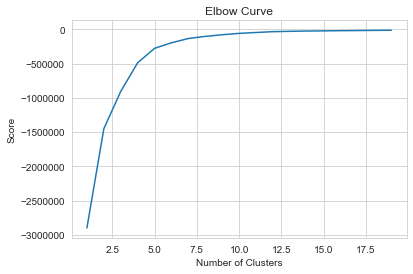

In [6]:
# Variable with the Longitude and Latitude
Z = df[['Car ID','Latitude','Longitude']]
K_clusters = range(1,20)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['Latitude']]
X_axis = df[['Longitude']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize the amount of clusters
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [7]:
#Let's define labels for location
kmeans = KMeans(n_clusters = 12, init ='k-means++')
kmeans.fit(Z[Z.columns[1:3]]) # Compute k-means clustering.
Z['cluster_label'] = kmeans.fit_predict(Z[Z.columns[1:3]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(Z[Z.columns[1:3]]) # Labels of each point

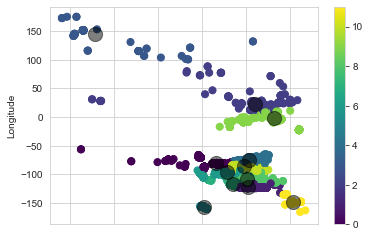

In [8]:
#put them on the plot
Z.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [9]:
#This is our silhouette score for k-means
print(metrics.silhouette_score(Z[Z.columns[1:3]], labels, metric='euclidean'))

0.6456396547584401


## DBSCAN Clustering for Location

In [10]:
# Defining the agglomerative clustering
dbscan_cluster_l = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster_l.fit_predict(Z[Z.columns[1:3]])

In [11]:
print(metrics.silhouette_score(Z[Z.columns[1:3]], clusters, metric='euclidean'))

0.0023567980682241657


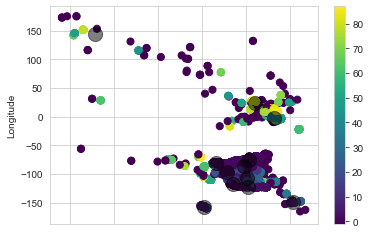

In [12]:
Z.plot.scatter(x = 'Latitude', y = 'Longitude', c = clusters, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

This is definitely won't be our choise based on the metrics

## Hierarchical clustering for location

In [13]:
from sklearn.cluster import AgglomerativeClustering

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=5)
# Fit model
clusters_h = agg_cluster.fit_predict(Z[Z.columns[1:3]])

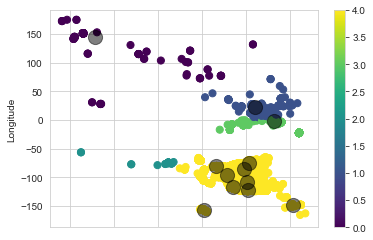

In [14]:
Z.plot.scatter(x = 'Latitude', y = 'Longitude', c = clusters_h, s=50, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [15]:
print(metrics.silhouette_score(Z[Z.columns[1:3]], clusters_h, metric='euclidean'))

0.43172051126894256


We'vew got a very good results with the clustering especially k-means. Let's keep this score an join the labels to our main dataset. We will use result from **k-means** where the score was 0.65.  

In [34]:
### Adding location cluster into the dataframe
df = df.merge(Z, left_on='Car ID', right_on='Car ID')

# Car category clusterization

In [39]:
df.head()

Car ID                                                URL      Make  \
0      92  https://turo.com/rentals/cars/ca/san-francisco...       bmw   
1     279  https://turo.com/rentals/cars/ca/hillsborough/...   porsche   
2     445  https://turo.com/rentals/cars/ca/berkeley/toyo...    toyota   
3     724  https://turo.com/rentals/cars/ca/san-jose/toyo...    toyota   
4     972  https://turo.com/rentals/cars/ca/santa-ana/inf...  infiniti   

      Model       Trim  Year  Color Transmission Fuel Type  Number of seats  \
0  3 series          0  2004  OTHER            A         0              0.0   
1       911  Carrera S  2006   GRAY            M       Gas              4.0   
2     prius          0  2010   BLUE            A         0              0.0   
3   corolla          0  2012  BLACK            A         0              0.0   
4       m35      Sport  2006  BLACK            A       Gas              5.0   

   ...    Category_y  Latitude_x  Longitude_x cluster_label_y    Category_x  \
0  ...  Intermediate   37.771757  -122.440658               1  intermediate   
1  ...        Exotic   37.578681  -122.363776               1        exotic   
2  ...       Economy   37.857234  -122.265831               1       economy   
3  ...  Intermediate   37.353274  -121.892823               1  intermediate   
4  ...  Intermediate   33.772218  -117.891395               7  intermediate   

  Category_code    Category_y Latitude_y Longitude_y  cluster_label  
0             6  Intermediate  37.771757 -122.440658              1  
1             5        Exotic  37.578681 -122.363776              1  
2             3       Economy  37.857234 -122.265831              1  
3             6  Intermediate  37.353274 -121.892823              1  
4             6  Intermediate  33.772218 -117.891395              7  

[5 rows x 84 columns]

In [40]:
#combining make and model into category name
df1 = pd.read_csv ('Category_DB.csv', encoding='ISO-8859–1')
df['for category']= df['Make']+df['Model']
df = pd.merge (df, df1[['Car ID', 'Category']], on  = 'Car ID', how="left")

In [41]:
#adjust some text errors
df.Make = df.Make.str.lower()
df.Model = df.Model.str.lower()
df.Category = df.Category.astype('category')
df.Category = df.Category.str.lower()
df = df[df['Category'].notnull()]

In [99]:
df.Category = df.Category.astype('category')
df['Category_code'] = df['Category'].cat.codes

In [100]:

df.head(10)

Car ID                                                URL      Make  \
0      92  https://turo.com/rentals/cars/ca/san-francisco...       bmw   
1     279  https://turo.com/rentals/cars/ca/hillsborough/...   porsche   
2     445  https://turo.com/rentals/cars/ca/berkeley/toyo...    toyota   
3     724  https://turo.com/rentals/cars/ca/san-jose/toyo...    toyota   
4     972  https://turo.com/rentals/cars/ca/santa-ana/inf...  infiniti   
5    1081  https://turo.com/rentals/cars/ca/san-leandro/h...     honda   
6    1085  https://turo.com/rentals/cars/ca/sunnyvale/hon...     honda   
7    1461  https://turo.com/rentals/trucks/ca/berkeley/to...    toyota   
8    1745  https://turo.com/rentals/cars/ca/los-angeles/f...    fisker   
9    1759  https://turo.com/rentals/cars/in/evansville/po...   porsche   

      Model       Trim  Year  Color Transmission Fuel Type  Number of seats  \
0  3 series          0  2004  OTHER            A         0              0.0   
1       911  Carrera S  2006   GRAY            M       Gas              4.0   
2     prius          0  2010   BLUE            A         0              0.0   
3   corolla          0  2012  BLACK            A         0              0.0   
4       m35      Sport  2006  BLACK            A       Gas              5.0   
5     civic          0  2009   GRAY            A         0              0.0   
6    accord          0  2010  BLACK            A         0              0.0   
7    tacoma       Base  2006   BLUE            A       Gas              4.0   
8     karma  Eco-Sport  2012   GRAY            A    Hybrid              4.0   
9       911    Carrera  2006  BLACK            M         0              4.0   

   ...  Make_toyota  Make_triumph  Make_vauxhall Make_volkswagen  Make_volvo  \
0  ...            0             0              0               0           0   
1  ...            0             0              0               0           0   
2  ...            1             0              0               0           0   
3  ...            1             0              0               0           0   
4  ...            0             0              0               0           0   
5  ...            0             0              0               0           0   
6  ...            0             0              0               0           0   
7  ...            1             0              0               0           0   
8  ...            0             0              0               0           0   
9  ...            0             0              0               0           0   

  Make_vw Make_yugo value_True Trans_M  Price per day_win  
0       0         0          0       0               90.0  
1       0         0          0       1              180.0  
2       0         0          0       0               80.0  
3       0         0          0       0               22.0  
4       0         0          0       0               13.0  
5       0         0          0       0               37.0  
6       0         0          0       0               81.0  
7       0         0          0       0               95.0  
8       0         0          1       0              127.0  
9       0         0          0       1              137.0  

[10 rows x 167 columns]

In [77]:
df.groupby("Category")["Category"].count()

Category
cargo van          25
convertible      2418
economy          6788
electric         1611
exotic           3901
intermediate    11157
minivan          1681
motorhome           5
premium          4924
premium suv      4697
retro             437
suv              5648
truck            1423
van               103
Name: Category, dtype: int64

In [44]:
df.groupby("Category_code")["Category_code"].count()

Category_code
0        25
1      2418
2      6788
3      1611
4      3901
5     11157
6      1681
7         5
8      4924
9      4697
10      437
11     5648
12     1423
13      103
Name: Category_code, dtype: int64

In [80]:
#Let's see how categories looking
Y.value_counts()/len(Y)

5     0.248940
2     0.151457
11    0.126021
8     0.109867
9     0.104802
4     0.087041
1     0.053952
6     0.037507
3     0.035945
12    0.031751
10    0.009751
13    0.002298
0     0.000558
7     0.000112
Name: Category_code, dtype: float64

# WORK ON CLASTERISATION AND DIMENSIONALITY REDUCTION

## Trsnsform non-numerical variables into dummies

In [45]:
df = pd.concat([df,pd.get_dummies(df.Convertible, prefix="Conv", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['Fuel Type'], prefix="fuel", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['Make'], prefix="Make", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['highValueVehicle'], prefix="value", drop_first=True)], axis=1)
df = pd.concat([df,pd.get_dummies(df['Transmission'], prefix="Trans", drop_first=True)], axis=1)

In [46]:
dummy_column_names = list(pd.get_dummies(df.Convertible, prefix="Conv", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['Fuel Type'], prefix="fuel", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['Make'], prefix="Make", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['highValueVehicle'], prefix="value", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df['Transmission'], prefix="Trans", drop_first=True).columns)

## Assign invoming and outcoming variables

In [47]:
X =  df[['Price per day', 'Year', 'Number of seats', 'Number of doors']+dummy_column_names]
#Let's keep one more set for the variable without price
X1 =  df[['Year', 'Number of seats', 'Number of doors']+dummy_column_names]
Y = df["Category_code"]

In [48]:
#Let's scale the variables 
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

## DIMENSIONALITY REDUCTION 

In [49]:
# Reduce it to two components for visualization and check how long will it take 
X_pca = PCA(2).fit_transform(X_std)

time_start = time.time()
X_pca = PCA(2).fit_transform(X_std)


print('PSA done! Time elapsed: {} seconds'.format(time.time()-time_start))

PSA done! Time elapsed: 0.07679605484008789 seconds


### UMAP

In [50]:
time_start = time.time()

umap_results = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

print('UMAP done! Time elapsed: {} seconds'.format(time.time()-time_start))

UMAP done! Time elapsed: 38.6958270072937 seconds


In [51]:
#we see that the UMAP technique is much longer and let's see how it's looking

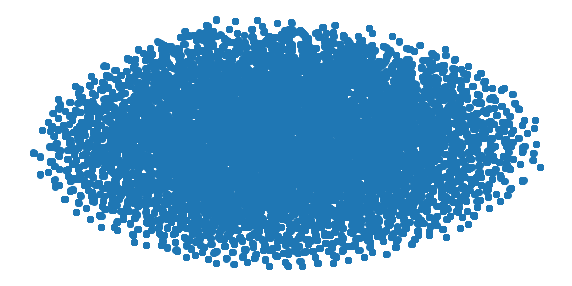

In [52]:
plt.figure(figsize=(10,5))
plt.scatter(umap_results[:, 0], umap_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

This isn't a good perfomace from a clustering perspective plus the calculation time is too high

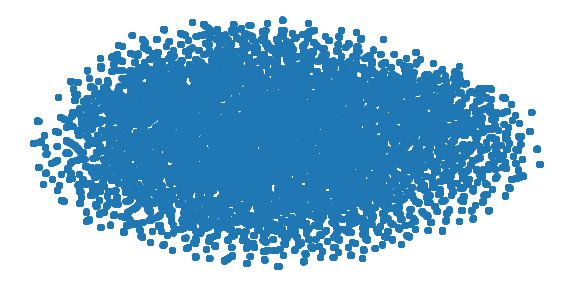

In [53]:
umap_results7 = umap.UMAP(n_neighbors=7,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X_std)

plt.figure(figsize=(10,5))
plt.scatter(umap_results7[:, 0], umap_results7[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

## 6.1. K-Means

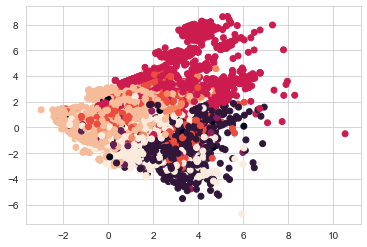

In [54]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=9, random_state=123).fit_predict(X_std)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1],  c=y_pred)
plt.show()

## K-means Evaluation

In [55]:
# Non-labeled verification:

In [56]:
labels = KMeans(n_clusters=7, random_state=123).fit_predict(X_std)
print(metrics.silhouette_score(X_pca, labels, metric='euclidean'))

0.13767906054356704


In [ ]:
#the score is very low since our goal is to be closer to 1. Let's try another techniques

## DBSCAN  (psa)

In [57]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA

In [74]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
X_pca = PCA(2).fit_transform(X_std)
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters_db_pc = dbscan_cluster.fit_predict(X_std)

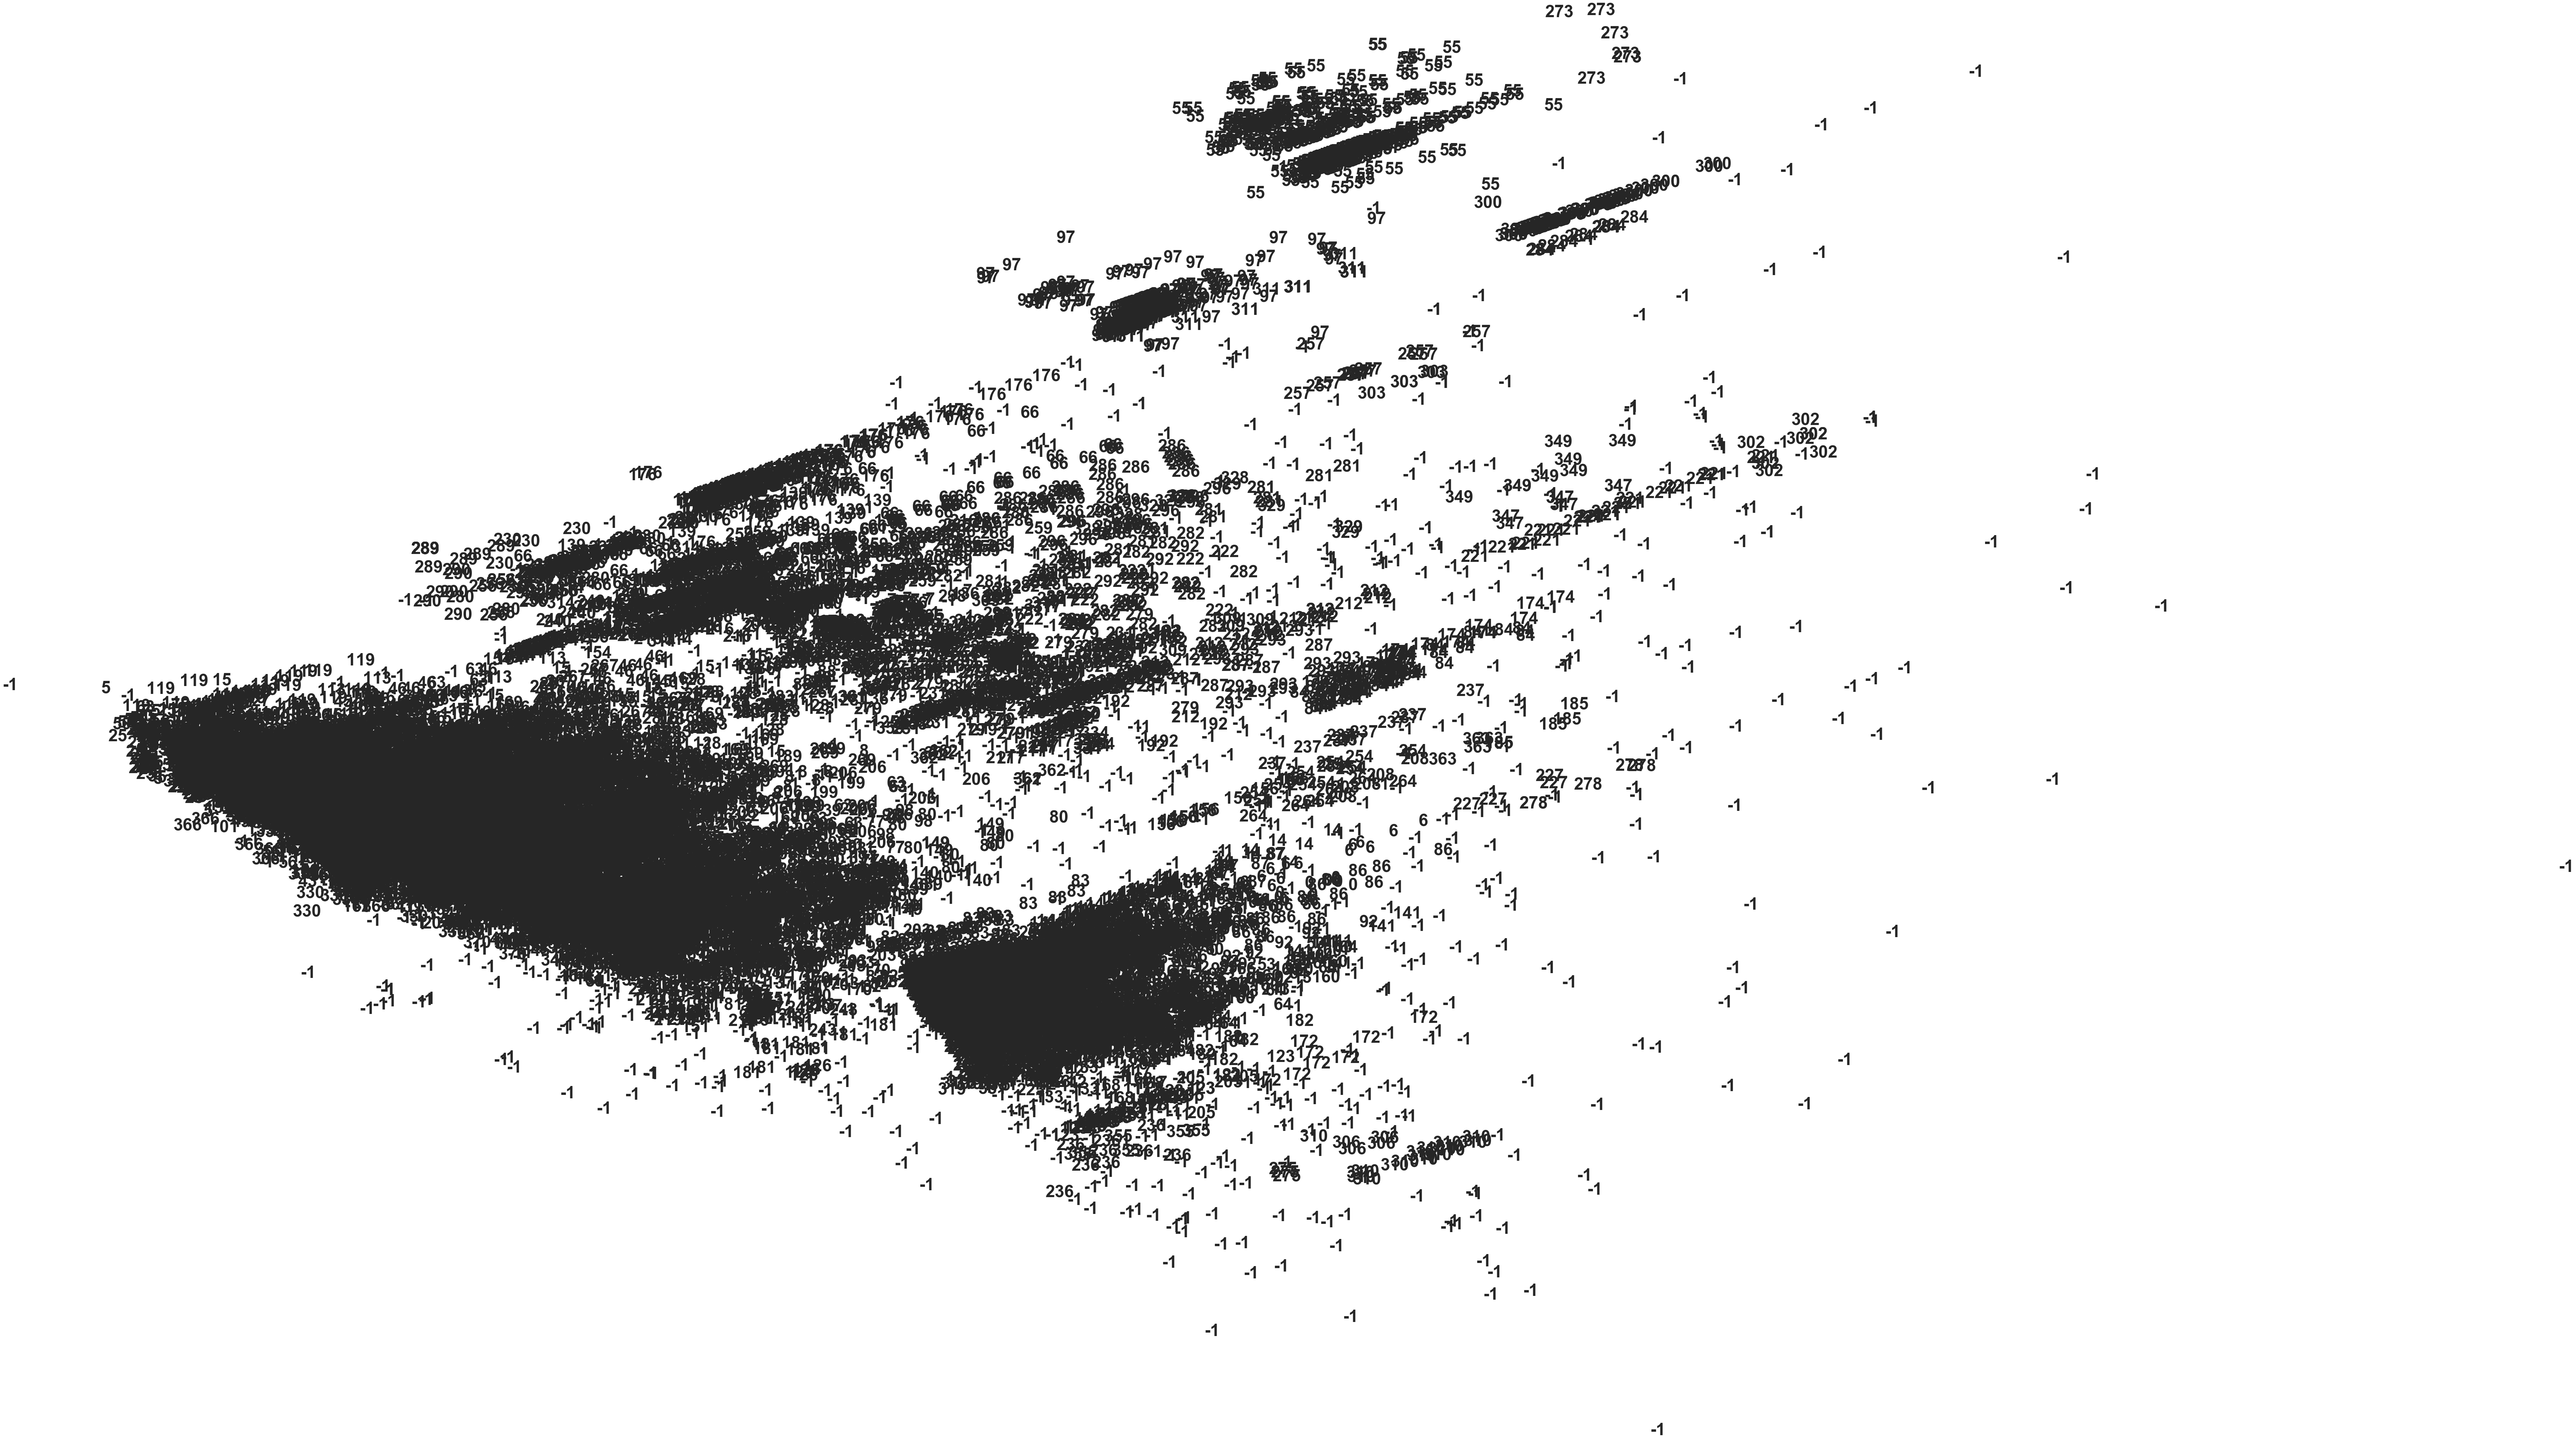

In [75]:
#plot the results
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'

for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters_db_pc[i]),
             fontdict={'weight': 'bold', 'size': 50}
        )
    
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [72]:
print(metrics.silhouette_score(X_std, clusters_db_pc, metric='euclidean'))

0.8957001493471506


### DBSCAN  (umap)

In [ ]:
#The score is much better. Let's try with UMAP dimensinality reduction

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters_umap = dbscan_cluster.fit_predict(umap_results7)

In [57]:
print(metrics.silhouette_score(X_std, clusters_umap, metric='euclidean'))

-0.529524664838877


This isn't a good numeber to use this reduction technique.

## Hierarchical clastering (psa)

In [58]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
Xpca = PCA(2).fit_transform(X_std)
from sklearn.cluster import AgglomerativeClustering

# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3)

# Fit model
clusters_h = agg_cluster.fit_predict(X_pca)

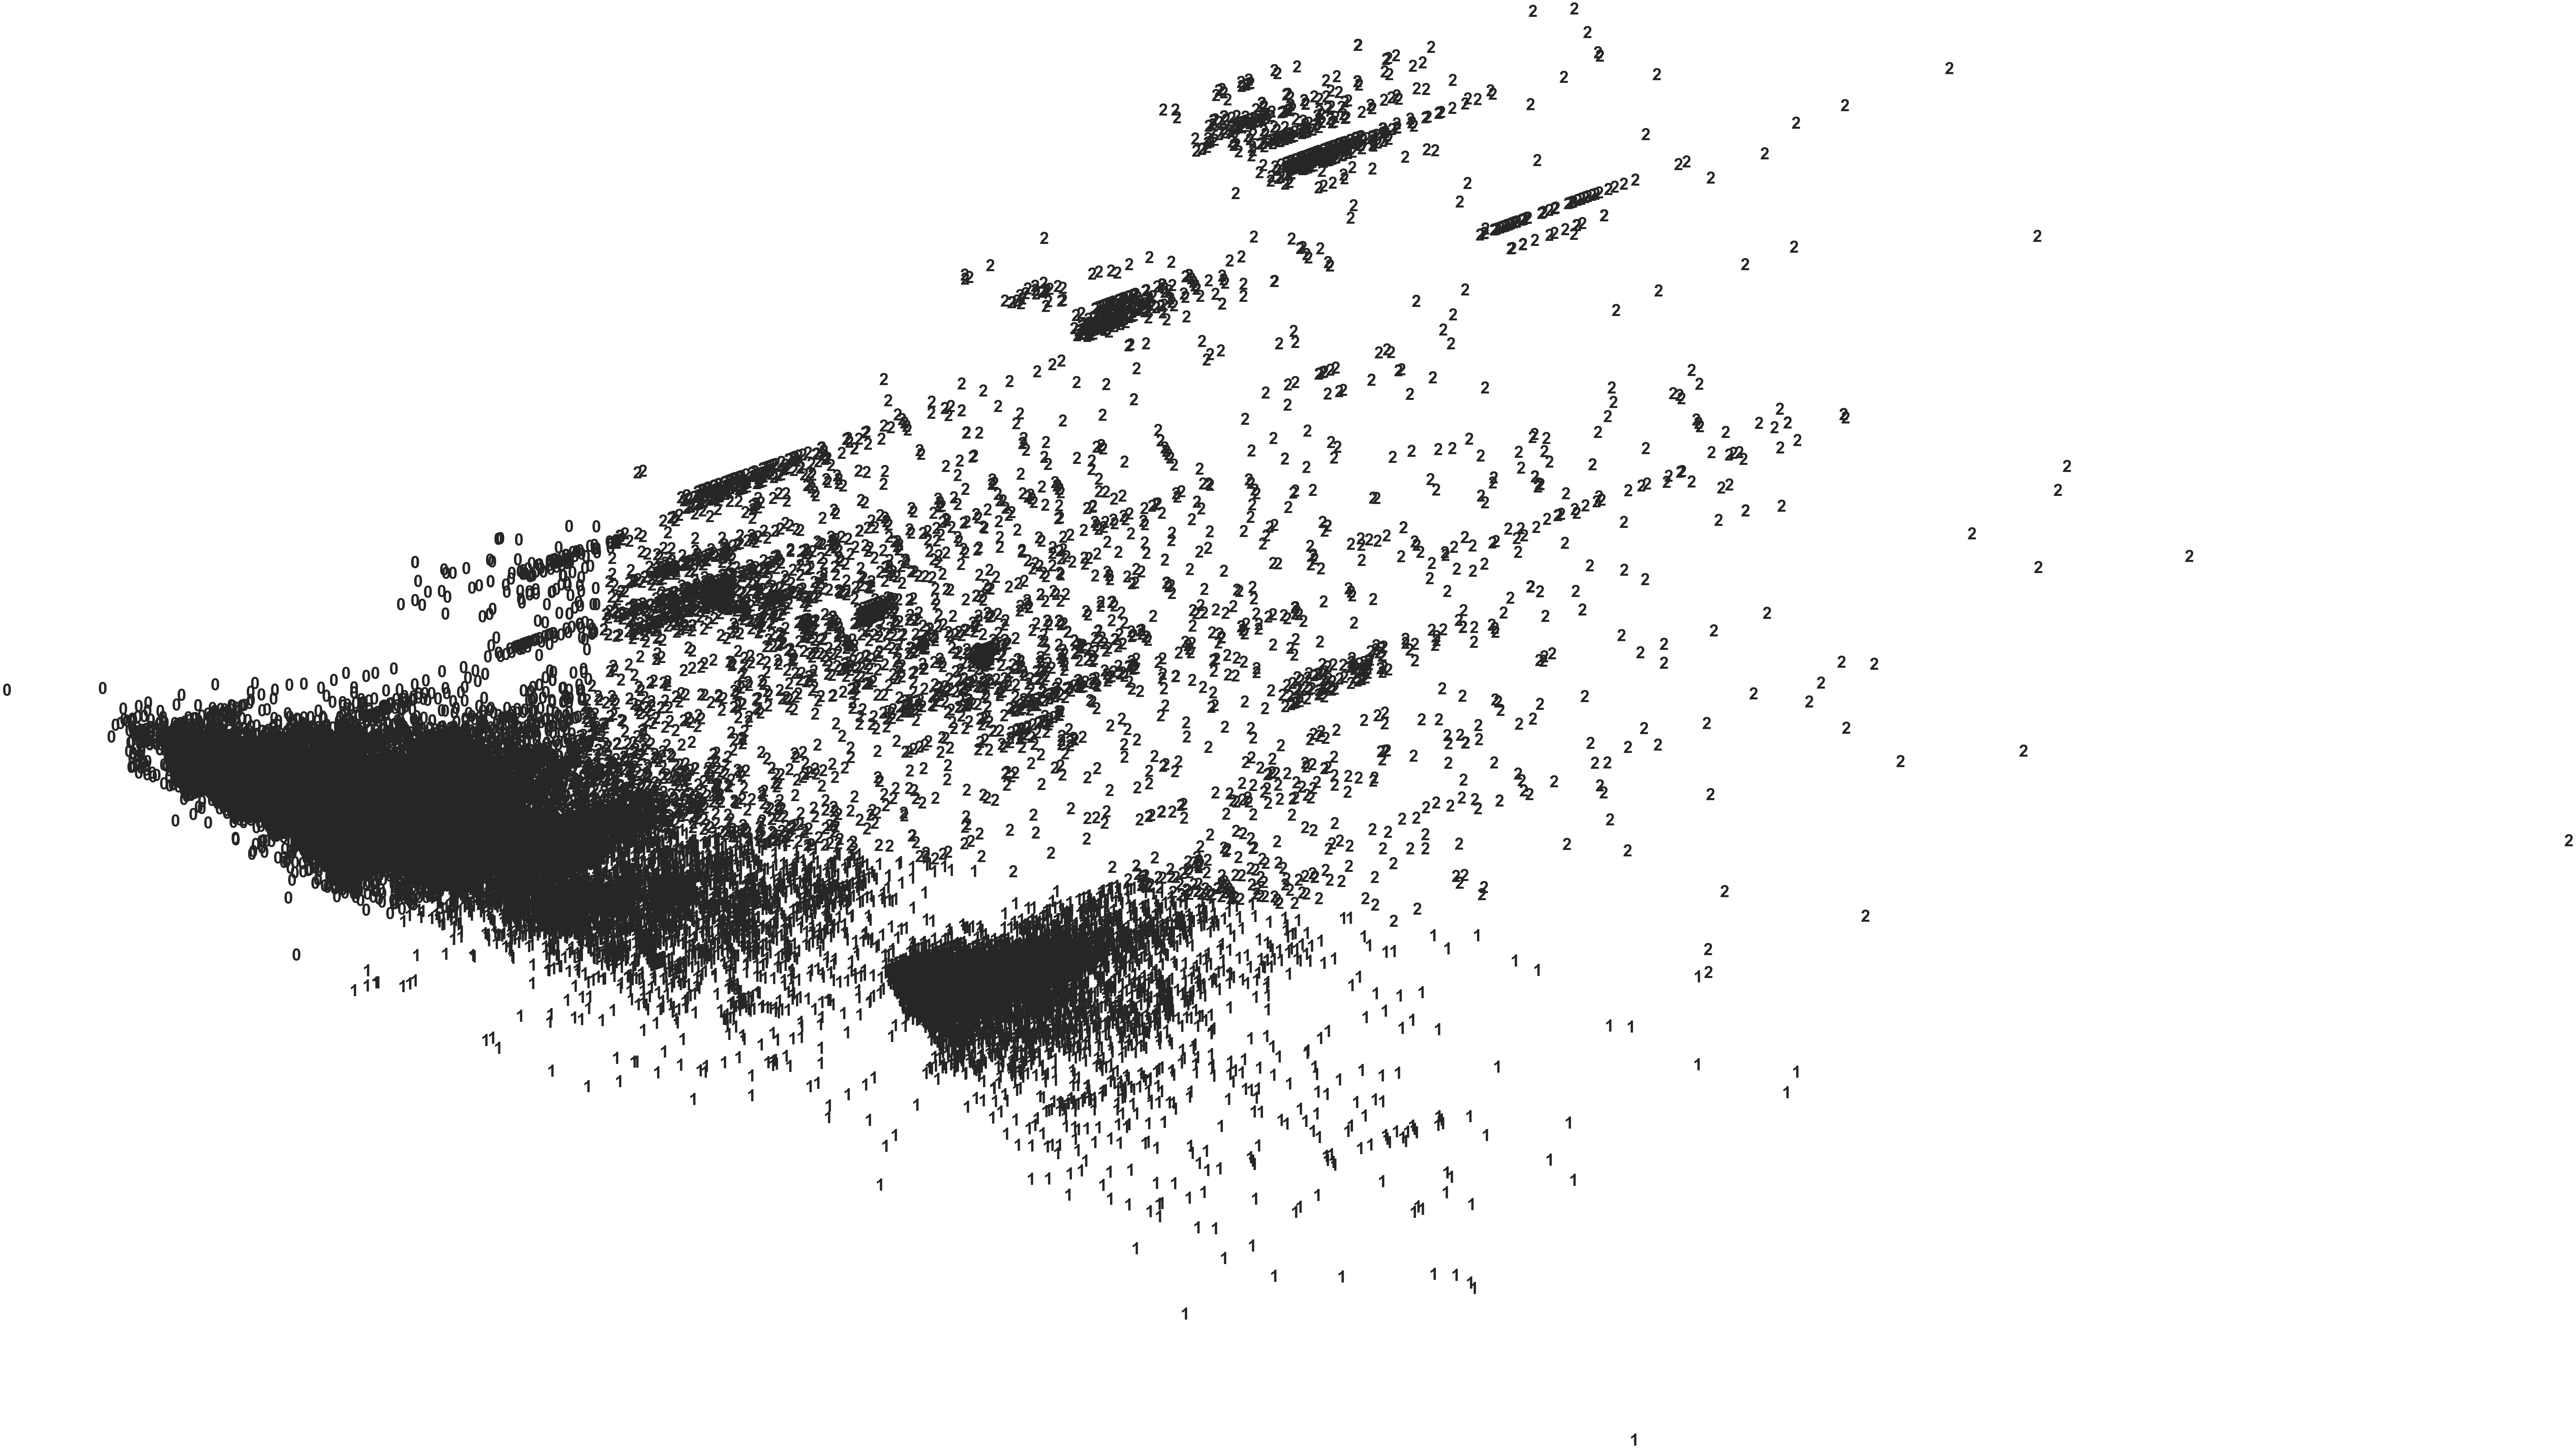

In [59]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters_h[i]),
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [60]:
print(metrics.silhouette_score(X_std, clusters_h, metric='euclidean'))

0.07522371146298965


This one doesn't work this good, let's try with UMAP


## Hierarchical clastering (umap)

In [62]:
print(metrics.silhouette_score(X_std, clusters_h_umap, metric='euclidean'))

-0.0018369254175829987


the rate is very low, we will be skipping it.

### UNSUPERVISED CLUSTERING. CONCLUSION

During unsupervised clustering process we were unable to define clear solution for our problem. 
However, based on the silhouette score the best result is coming from DBSCAN clasterisation using pca technique was high we still can't rely on it. We need to go with more sophisticated approach since our variables contain mixed (numeric and non-numeric and categorical) types of data. 

In this case we need to move forward and try to create a classificator with neural network to be able to assign the category for all new cars that will be add into the system. 

## Multi Layer Perceptron model

The power of neural networks come from their ability to learn the representation in the training data and how to best relate it to the output variable that you want to predict. We will try to use MLP model as well as Random Forest Classifier and compare the performance

In [82]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [83]:
mlp.score(X, Y)

0.6286090410103083

the score is pretty good. Let's try to do a cross validation for this

In [84]:
Y.value_counts()/len(Y)

5     0.248940
2     0.151457
11    0.126021
8     0.109867
9     0.104802
4     0.087041
1     0.053952
6     0.037507
3     0.035945
12    0.031751
10    0.009751
13    0.002298
0     0.000558
7     0.000112
Name: Category_code, dtype: float64

In [85]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X, Y, cv=5)

array([0.47391304, 0.54466377, 0.49665328, 0.6543141 , 0.6141996 ])

In [ ]:
The cross validation scores are around 0.54 in average.

Let's try it with the standartized X values - X_std

In [86]:
# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X_std, Y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1000,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [87]:
mlp.score(X_std, Y)

0.7390334240706858

This is definitely much better. We've got our model explained by 10points better when our data is standartized

In [89]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X_std, Y, cv=5)

array([0.59253066, 0.63521802, 0.68987059, 0.72575064, 0.69591427])

#This is a solid result for the data so we can procees with this

Let's try another clasifier to see if our results can go higher

## Random forest classifier

In [91]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
cross_val_score(rfc, X, Y, cv=5)

array([0.56109253, 0.6016505 , 0.65896921, 0.67496372, 0.65539183])

these numbers are good but the best performance we've got with the 

# CONCLUSIONS
In this capstone we were trying to solve the **problem of clustering the data**.
Our original raw data has variables that should be clustered in order to make more precise predictions and to reduce the amount of noise and overfitting. Unsupervised clustering is mainly a process of putting several objects into one bin while models is an ability to predict an outcome. 
Two issues were solved:
- clustering listings by location 
- clustering by car characteristics (price, make, type of fuel, high/not high value of the car


**1. Location clustering:**
The unsupervised learning worked well for clustering numerical information with Lat and Long (we got the silhouette score on the level of 0.65 with k-means
. 

**2. Car category clustering**
    we tried several unsupervised learning techniues but non of them, work good for hybrid variables. We were able to achieve pretty high silghouette score with dbscan (0.84) but it doesn't work good along with the labeled data. We tried another methods as well. K-means and hierarchical clustering are good at finding circular (or convex) clusters, which makes them great tools for identifying well-separated clusters. But, unfortunately, they're not good at identifying clusters that are not well-separated or that have non-convex shapes such as rings inside rings. Anyway, this problem  better should be solved with the supervised model since there are more mixed data involved, it has non-linear connections. For this purpose we used **supervised neural network classifier** that gave us around 0.70 score. We check models with cross validation score to make sure there is no overfitting in the data
These findings are extremelly useful for the development an investment tool in order to predict potential earnings from sharing cars on the platform. We're going to continue our work on this data set in order to increase the relaibality of our calculations.